# Data preparation

## emotion label + path to file

In [29]:
#!/home/judehey/miniconda3/envs/myenv/bin/python

import pandas as pd
import numpy as np
import os

pathToData='data/emodb/wav/'
imgsPath='imgs/'
modelsPath='models/'

emotion, file_path = [], []

# iterate over .wav files in data dir and get label
for filename in os.listdir(pathToData):
    emotion.append(filename[5]) # emotion label
    file_path.append(pathToData + filename) # path to file
    

# make data frame out of labels and translate them
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({'W': 'anger', 'L': 'boredom', 'E': 'disgust', 'A': 'anxiety', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'})

audio_df = pd.concat([pd.DataFrame(file_path), audio_df], axis=1)
audio_df.columns = ['path', 'emotion']

df = audio_df

df

,path,emotion
0,data/wav/13a01Nb.wav,neutral
1,data/wav/14a05Fa.wav,happiness
2,data/wav/14a02Fd.wav,happiness
3,data/wav/03a05Nd.wav,neutral
4,data/wav/03b02Wb.wav,anger
...,...,...
530,data/wav/08b02Ff.wav,happiness
531,data/wav/12b10Ld.wav,boredom
532,data/wav/15b10Ac.wav,anxiety
533,data/wav/08b09Ab.wav,anxiety


## feature extraction

In [30]:
import librosa

# log-mel spectrogram

logMelSpecVal, counter = [], 0

for fpath in df['path']:
    wavf, sample_rate = librosa.load(fpath, res_type='kaiser_fast', duration=3, sr=44100, offset=0.5)
    spectrogram = librosa.feature.melspectrogram(y=wavf, sr=sample_rate, n_mels=128, fmax=8000)
    db_spec = librosa.power_to_db(spectrogram)
    log_spectrogram = np.mean(db_spec, axis=0)
    logMelSpecVal.append(log_spectrogram)
    
    
df = pd.concat([df, pd.DataFrame(logMelSpecVal)], axis=1)
df.head()

,path,emotion,0,1,2,3,4,5,6,7,...,249,250,251,252,253,254,255,256,257,258
0,data/wav/13a01Nb.wav,neutral,-8.086758,-10.989127,-17.834589,-16.723110,-15.838402,-19.050850,-26.059645,-30.654091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data/wav/14a05Fa.wav,happiness,-40.019638,-37.640614,-33.136181,-27.106003,-22.428127,-16.950409,-13.119109,-11.845717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data/wav/14a02Fd.wav,happiness,-4.900698,-6.856063,-12.862519,-12.868782,-10.484149,-5.974355,-4.934223,-6.173040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data/wav/03a05Nd.wav,neutral,-12.783932,-17.369202,-33.136139,-39.185593,-44.047306,-45.105534,-45.392887,-30.665262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data/wav/03b02Wb.wav,anger,-15.220204,-14.747183,-16.459600,-16.539696,-15.437865,-18.557196,-33.965996,-47.033562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plotting

## class imbalance

['neutral' 'happiness' 'anger' 'sadness' 'disgust' 'boredom' 'anxiety']


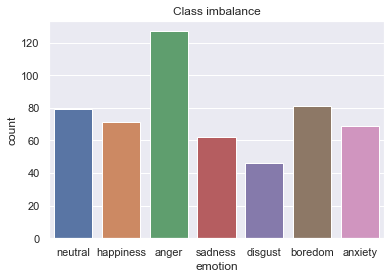

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
print(df['emotion'].unique())
sns.set_theme(style='darkgrid')
sns.countplot(x = 'emotion', data = df)
plt.title('Class imbalance')
plt.savefig(imgsPath + 'class_imbalance.png')
plt.show()

## waveform

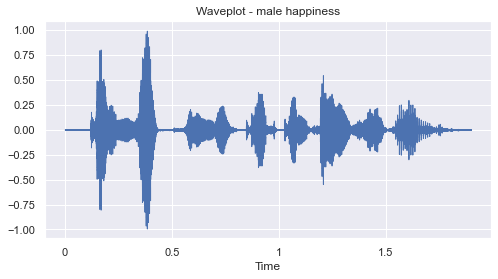

In [32]:
import librosa.display
from IPython.display import Audio

# waveplot
wavf, sr = librosa.load('data/wav/03a01Fa.wav')

plt.figure(figsize = (8, 4))
librosa.display.waveshow(wavf, sr = sr)
plt.title('Waveplot - male happiness')
plt.savefig(imgsPath + 'waveplot_male_happiness.png')
plt.show()

## log-mel spectrogram

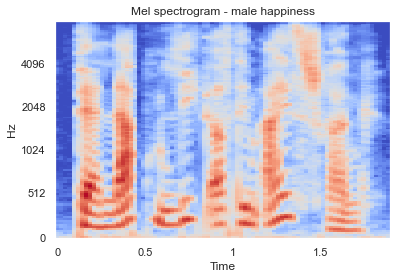

In [33]:
# log-mel spectrogram
spectrogram = librosa.feature.melspectrogram(y=wavf, sr=sr, n_mels=128, fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel spectrogram - male happiness')
plt.savefig(imgsPath + 'mel_spec_male_happiness.png')
plt.show()

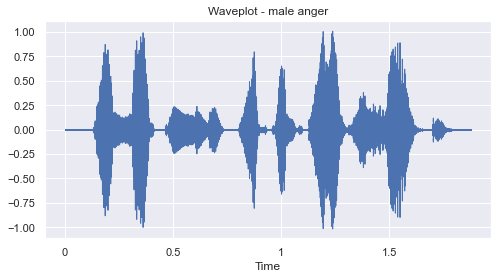

In [34]:
# waveplot
wavf, sr = librosa.load('data/wav/03a01Wa.wav')

plt.figure(figsize = (8, 4))
librosa.display.waveshow(wavf, sr = sr)
plt.title('Waveplot - male anger')
plt.savefig(imgsPath + 'waveplot_male_anger.png')
plt.show()

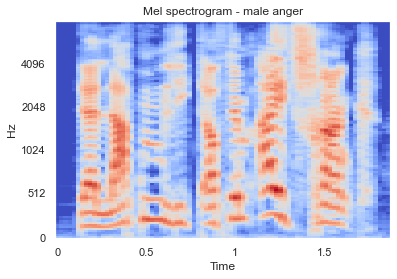

In [35]:
# log-mel spectrogram
spectrogram = librosa.feature.melspectrogram(y=wavf, sr=sr, n_mels=128, fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel spectrogram - male anger')
plt.savefig(imgsPath + 'mel_spec_male_anger.png')
plt.show()

# Data split

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df.drop(columns='path', inplace = True)
df=df.fillna(0)

X = df.iloc[:, :].drop(columns=['emotion'])
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, stratify=y)

print(X_train.head())
print(y_train.head())

           0          1          2          3          4          5    \
216 -21.473753 -22.812094 -28.732403 -38.356800 -39.756058 -40.059387   
47  -13.432587 -11.244164 -13.155388 -12.491542 -14.032743 -20.064175   
368  -4.578898  -6.618506 -17.131145 -18.158821 -18.384062 -15.706916   
95  -27.245993 -28.664410 -38.624542 -24.930969 -17.051214 -17.419849   
106 -21.282410 -25.466337 -29.647141 -24.135691 -19.393095 -12.690125   

           6          7          8          9    ...        249       250  \
216 -40.066116 -42.240410 -41.545372 -41.620018  ... -11.876195 -13.88211   
47  -22.246584 -19.871069 -16.895470 -17.574551  ...   0.000000   0.00000   
368 -12.147253 -11.748201 -16.506796 -26.647839  ...   0.000000   0.00000   
95  -19.521053 -20.410931 -20.300123 -17.071211  ...   0.000000   0.00000   
106  -8.828571 -10.934075 -14.305446 -18.667658  ...   0.000000   0.00000   

           251        252        253        254        255        256  \
216 -16.160555 -16.929451

# Data preprocessing

In [37]:
from keras.utils import to_categorical

# normalization (z-score, values between -1 and 1)
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# turn data into arrays for keras
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(y_train.shape)
print(y_test.shape)

# label one hot encoding
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:3])

print(lb.classes_)

# data reshaping
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)

(428,)
(107,)
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
['anger' 'anxiety' 'boredom' 'disgust' 'happiness' 'neutral' 'sadness']
(428, 259, 1)


# CNN model architecture

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.utils import plot_model

#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(7, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 250, 64)           704       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 128)           

# Model training and export


Epoch 00001: val_accuracy improved from -inf to 0.24299, saving model to models/model_1_CNN
INFO:tensorflow:Assets written to: models/model_1_CNN/assets

Epoch 00002: val_accuracy did not improve from 0.24299

Epoch 00003: val_accuracy improved from 0.24299 to 0.33645, saving model to models/model_1_CNN
INFO:tensorflow:Assets written to: models/model_1_CNN/assets

Epoch 00004: val_accuracy did not improve from 0.33645

Epoch 00005: val_accuracy did not improve from 0.33645

Epoch 00006: val_accuracy did not improve from 0.33645

Epoch 00007: val_accuracy did not improve from 0.33645

Epoch 00008: val_accuracy improved from 0.33645 to 0.34579, saving model to models/model_1_CNN
INFO:tensorflow:Assets written to: models/model_1_CNN/assets

Epoch 00009: val_accuracy improved from 0.34579 to 0.37383, saving model to models/model_1_CNN
INFO:tensorflow:Assets written to: models/model_1_CNN/assets

Epoch 00010: val_accuracy did not improve from 0.37383

Epoch 00011: val_accuracy did not impr

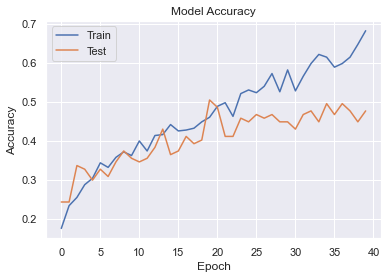

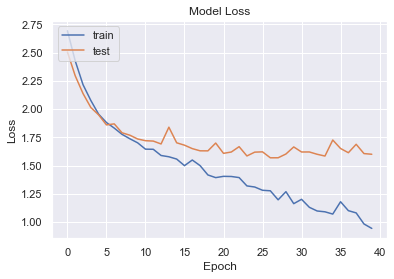

In [39]:
from keras.callbacks import ModelCheckpoint

# use checkpoints to save best model
checkpoint=ModelCheckpoint(modelsPath + 'model_1_CNN', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# fit model
model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=0)

# plot model accuracy and loss over epochs
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(imgsPath + 'Initial_Model_Accuracy.png')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(imgsPath + 'Initial_Model_loss.png')
plt.show()

# Results

## accuracy and loss

In [40]:
# loss and accuracy percentage on test set
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

4/4 [==============================] - 0s 71ms/step - loss: 1.6003 - accuracy: 0.4766
Loss of the model is -  1.600253701210022
4/4 [==============================] - 0s 49ms/step - loss: 1.6003 - accuracy: 0.4766
Accuracy of the model is -  47.663551568984985 %


In [41]:
# predictions
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,boredom,sadness
2,neutral,boredom
3,happiness,anger
4,happiness,anger
5,anxiety,anger
6,anxiety,anxiety
7,happiness,anxiety
8,happiness,happiness
9,neutral,boredom


## confusion matrix

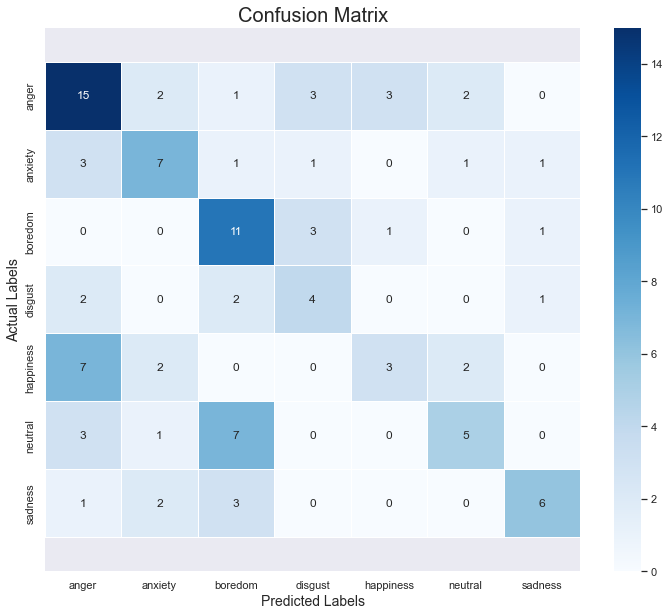

In [42]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgsPath + 'Initial_Model_Confusion_Matrix.png')
plt.show()

In [43]:
print(classification_report(actual, predictions, target_names = ['angry','anxiety','boredom','disgust','happiness','neutral','sadness']))

              precision    recall  f1-score   support

       angry       0.48      0.58      0.53        26
     anxiety       0.50      0.50      0.50        14
     boredom       0.44      0.69      0.54        16
     disgust       0.36      0.44      0.40         9
   happiness       0.43      0.21      0.29        14
     neutral       0.50      0.31      0.38        16
     sadness       0.67      0.50      0.57        12

    accuracy                           0.48       107
   macro avg       0.48      0.46      0.46       107
weighted avg       0.48      0.48      0.47       107

